# Analiza prometnih nesreč v Sloveniji

In [341]:
import pandas as pd
from pyproj import Transformer

years = range(2014, 2024)
dataFrames = []

for year in years:
    dataFrame = pd.read_csv(f"./data/pn{year}.csv", encoding="cp1250", delimiter=";")
    dataFrame["Year"] = year
    dataFrames.append(dataFrame)
    
#Vse v en dataframe (lažje iskanje)
data = pd.concat(dataFrames, ignore_index=True)

#Spremenimo , v . in kjer je NAN damo na 0
alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

#Spremenim x in y v lat in lon

data["x"] = pd.to_numeric(data["GeoKoordinataX"], errors="coerce")
data["y"] = pd.to_numeric(data["GeoKoordinataY"], errors="coerce")
data = data.dropna(subset=["x", "y"])

transformer = Transformer.from_crs("EPSG:3912", "EPSG:4326", always_xy=True)

lons, lats  = transformer.transform(data["y"].values, data["x"].values)

data["lon"] = lons
data["lat"] = lats

## Klasifikacija nesreč

Na spodnjem stolpčnem diagramu smo prikazali število prometnih nesreč v Sloveniji v letu 2023, razvrščenih glede na njihovo klasifikacijo. Podatki so razdeljeni v več kategorij, med katerimi prevladujejo nesreče z materialno škodo.

Ta vrsta nesreče predstavlja daleč največji delež vseh obravnavanih primerov, kar kaže na to, da so najpogostejše situacije, kjer ne pride do telesnih poškodb, temveč zgolj do škode na vozilih ali infrastrukturi.

Alkohol


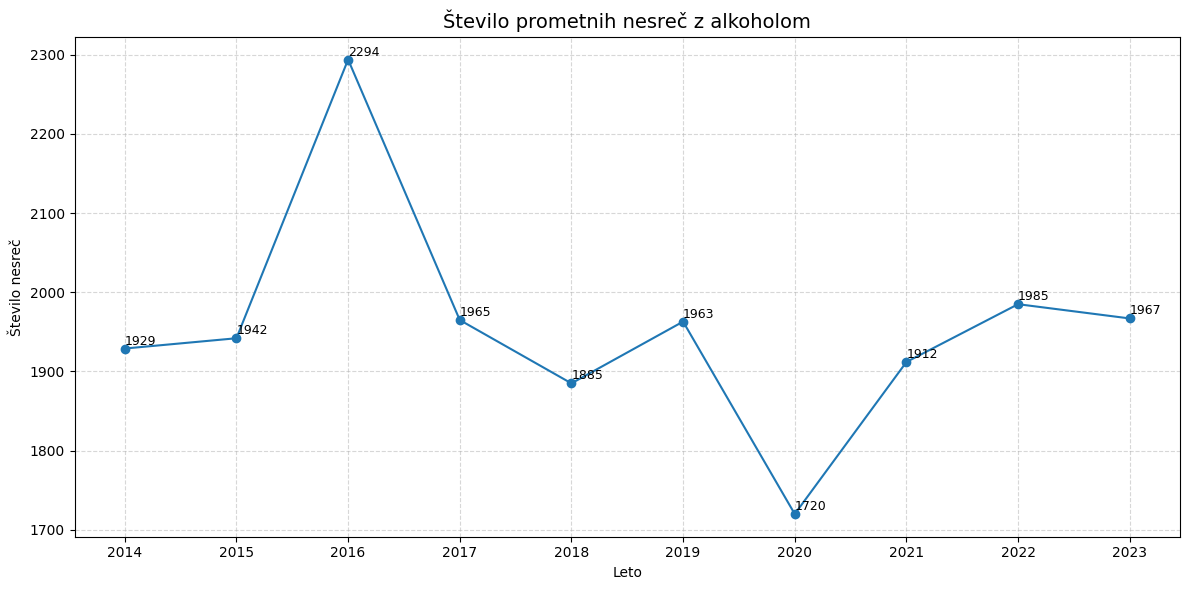

In [342]:
import matplotlib.pyplot as plt

alko_present = alko > 0
data["AlkoholPrisoten"] = alko_present

yearly_stats = data.groupby("Year").agg(
    Skupaj=("AlkoholPrisoten", "count"),
    ZAlkoholom=("AlkoholPrisoten", "sum")
)
yearly_stats["Odstotek"] = (yearly_stats["ZAlkoholom"] / yearly_stats["Skupaj"]) * 100

plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["ZAlkoholom"], marker="o")
for year, value in yearly_stats["ZAlkoholom"].items():
    plt.text(year, value + 5, value, fontsize=9)
plt.title("Število prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("alkoholStNesrec.png", dpi=300, bbox_inches="tight")
plt.show()


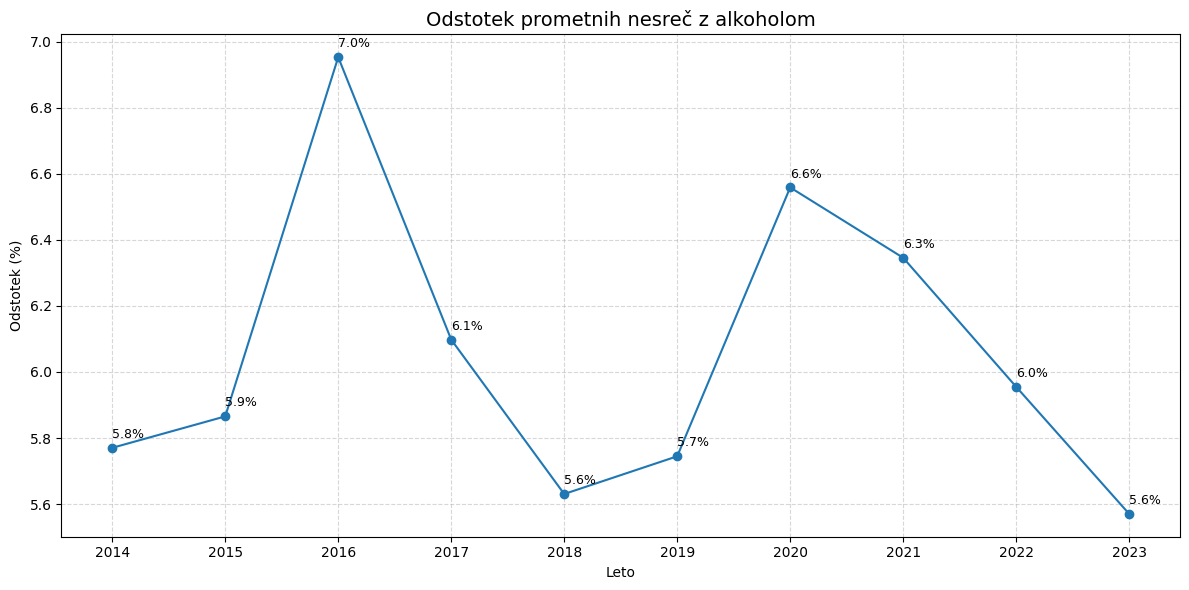

In [343]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats["Odstotek"], marker="o")
for year, value in yearly_stats["Odstotek"].items():
    plt.text(year, value + 0.03, f"{value:.1f}%", fontsize=9)
plt.title("Odstotek prometnih nesreč z alkoholom", fontsize=14)
plt.xlabel("Leto")
plt.ylabel("Odstotek (%)")
plt.xticks(yearly_stats.index)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

Število nesreč z opravljenim alkotestom: 19562
Pod 0.24 mg/l: 4643 (23.73%)
Nad 0.24 mg/l (prekršek): 14919 (76.27%)


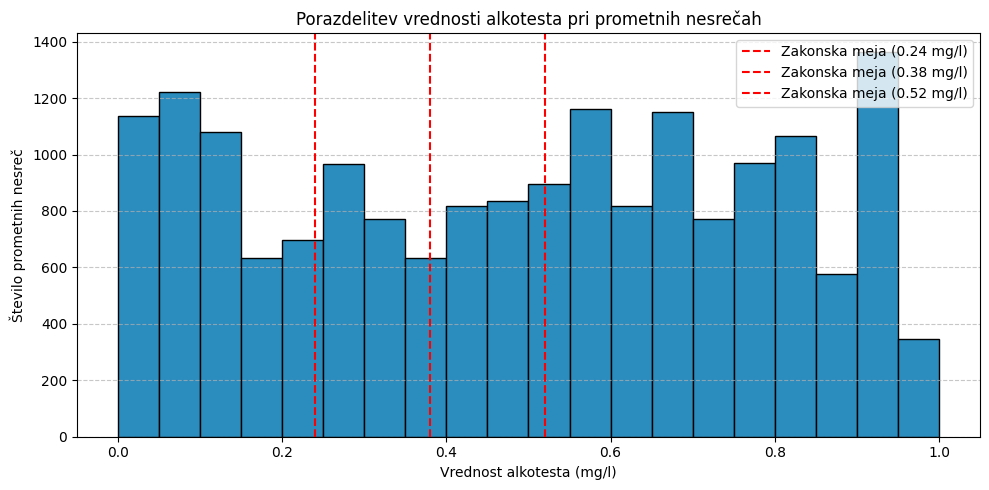

In [344]:
import matplotlib.pyplot as plt

alko_values = alko[alko > 0]

pod_mejo = (alko_values < 0.24).sum()
nad_mejo = (alko_values >= 0.24).sum()
skupaj = pod_mejo + nad_mejo

print(f"Število nesreč z opravljenim alkotestom: {skupaj}")
print(f"Pod 0.24 mg/l: {pod_mejo} ({pod_mejo / skupaj:.2%})")
print(f"Nad 0.24 mg/l (prekršek): {nad_mejo} ({nad_mejo / skupaj:.2%})")

bins = [i * 0.05 for i in range(0, 21)]

plt.figure(figsize=(10, 5))
plt.hist(alko_values, bins=bins, edgecolor='black', color="#2b8cbe")
plt.axvline(0.24, color='red', linestyle='--', label='Zakonska meja (0.24 mg/l)')
plt.axvline(0.38, color='red', linestyle='--', label='Zakonska meja (0.38 mg/l)')
plt.axvline(0.52, color='red', linestyle='--', label='Zakonska meja (0.52 mg/l)')

plt.xlabel("Vrednost alkotesta (mg/l)")
plt.ylabel("Število prometnih nesreč")
plt.title("Porazdelitev vrednosti alkotesta pri prometnih nesrečah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


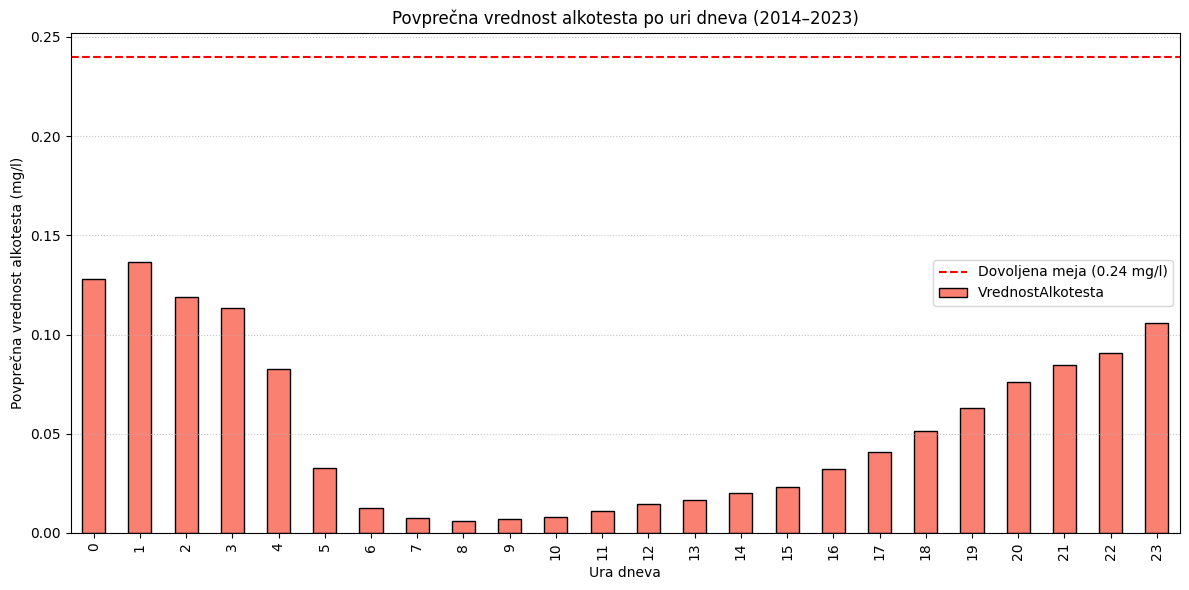

In [345]:
import pandas as pd
import matplotlib.pyplot as plt

alko_data = data.copy()
alko_data["VrednostAlkotesta"] = pd.to_numeric(
    alko_data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip(), 
    errors="coerce"
)
alko_data = alko_data.dropna(subset=["VrednostAlkotesta"])
alko_data = alko_data[alko_data["VrednostAlkotesta"] >= 0]

alko_data["UraPN"] = alko_data["UraPN"].astype(int)

avg_by_hour = alko_data.groupby("UraPN")["VrednostAlkotesta"].mean()

plt.figure(figsize=(12, 6))
avg_by_hour.plot(kind="bar", color="salmon", edgecolor="black")
plt.axhline(y=0.24, color="red", linestyle="--", label="Dovoljena meja (0.24 mg/l)")
plt.xlabel("Ura dneva")
plt.ylabel("Povprečna vrednost alkotesta (mg/l)")
plt.title("Povprečna vrednost alkotesta po uri dneva (2014–2023)")
plt.legend()
plt.grid(axis="y", linestyle=":", alpha=0.7)
plt.tight_layout()

plt.show()


# Zemljevid

In [376]:
import pandas as pd
from shapely.geometry import shape, Point
import json

with open("./data/si.json", "r", encoding="utf-8") as f:
    slovenia_map = json.load(f)

data_2023 = data[data["Year"] == 2023]


In [377]:
obcine = []
for idx, row in data_2023.iterrows():
    point = Point(row["lon"], row["lat"])

    found = None
    for feature in slovenia_map["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            found = feature["properties"].get("name", "Neznano")
            break

    obcine.append(found)

data_2023["Obcina"] = obcine



C:\Users\Tilen\AppData\Local\Temp\ipykernel_16828\175959964.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



import numpy as np
import geopandas as gpd
import plotly.express as px

accident_counts = data_2023.groupby("Obcina").size().reset_index(name="accidents")

slovenia_map = gpd.read_file("./data/si.json")
slovenia_map = slovenia_map.merge(accident_counts, left_on="name", right_on="Obcina", how="left")
slovenia_map["accidents"] = slovenia_map["accidents"].fillna(0)

slovenia_map["log_accidents"] = np.log1p(slovenia_map["accidents"]) 

fig = px.choropleth_map(
    slovenia_map,
    geojson=slovenia_map.geometry,
    locations=slovenia_map.index,
    color="log_accidents",
    color_continuous_scale="Reds",
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    opacity=0.6,
    hover_data={
        "name": True,
        "accidents": True,
        "log_accidents": False
    },
    labels={"accidents": "Število nesreč"},
    title="Prometne nesreče po občinah (2023)",
    height=800
)

fig.show()


In [ ]:
import numpy as np
import geopandas as gpd
import plotly.express as px

accident_counts = data_2023.groupby("Obcina").size().reset_index(name="accidents")

slovenia_map = gpd.read_file("./data/si.json")
slovenia_map = slovenia_map.merge(accident_counts, left_on="name", right_on="Obcina", how="left")
slovenia_map["accidents"] = slovenia_map["accidents"].fillna(0)

slovenia_map["log_accidents"] = np.log1p(slovenia_map["accidents"]) 

fig = px.choropleth_map(
    slovenia_map,
    geojson=slovenia_map.geometry,
    locations=slovenia_map.index,
    color="log_accidents",
    color_continuous_scale="Reds",
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    opacity=0.6,
    hover_data={
        "name": True,
        "accidents": True,
        "log_accidents": False
    },
    labels={"accidents": "Število nesreč"},
    title="Prometne nesreče po občinah (2023)",
    height=800
)

fig.show()


In [381]:
fig = px.scatter_map(
    data_2023,
    lat="lat",
    lon="lon",
    hover_name="OpisKraja",
    color_discrete_sequence=["red"],
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    height=800,
    title="Prometne nesreče v letu 2023 (lokacije)"
)

fig.update_layout(map_style="open-street-map")
fig.show()


In [383]:
smrtne = data[data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM"]

fig = px.scatter_map(
    smrtne,
    lat="lat",
    lon="lon",
    hover_name="OpisKraja",
    color_discrete_sequence=["red"],
    zoom=7,
    center={"lat": 46.0, "lon": 14.5},
    height=800,
    title="Smrtne nesreče (lokacije)"
)

fig.update_layout(map_style="open-street-map")
fig.show()

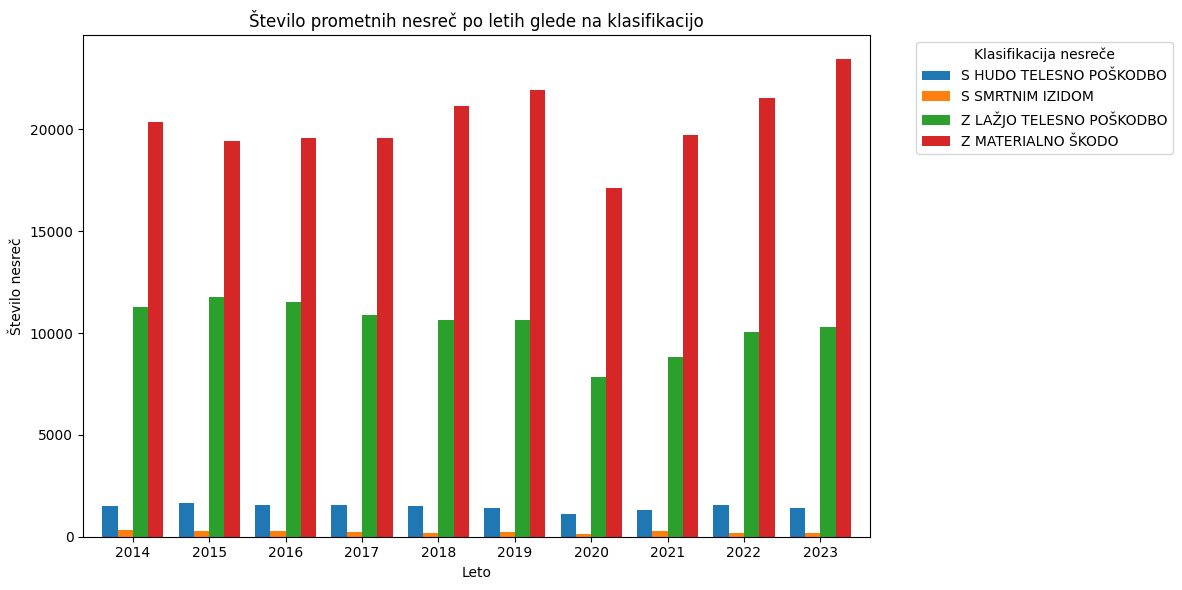

In [369]:
severity_by_year = data.groupby(["Year", "KlasifikacijaNesrece"]).size().unstack(fill_value=0)
severity_by_year = severity_by_year.sort_index()

severity_by_year.plot(
    kind='bar',
    stacked=False,
    figsize=(12, 6),
    width=0.8
)

plt.title("Število prometnih nesreč po letih glede na klasifikacijo")
plt.xlabel("Leto")
plt.ylabel("Število nesreč")
plt.legend(title="Klasifikacija nesreče", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

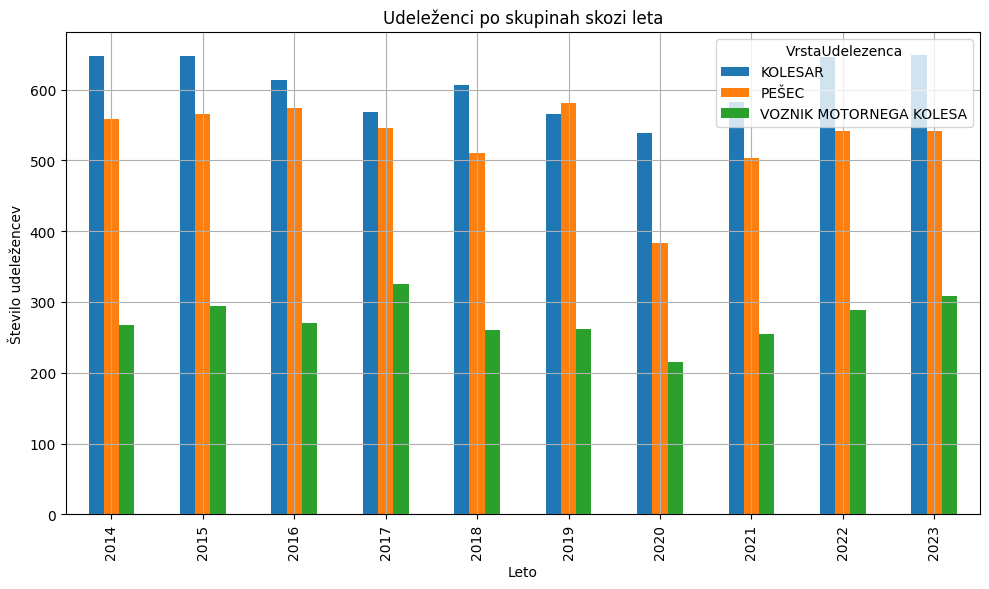

In [370]:
ciljne_skupine = ["PEŠEC", "KOLESAR", "VOZNIK MOTORNEGA KOLESA"]

udelezenci_filtrirani = data[data['Povzrocitelj'] != 'POVZROČITELJ']
udelezenci_filtrirani = udelezenci_filtrirani[udelezenci_filtrirani["VrstaUdelezenca"].isin(ciljne_skupine)]

udelezenci_po_letih = (
    udelezenci_filtrirani
    .groupby(["Year", "VrstaUdelezenca"])
    .size()
    .unstack(fill_value=0)
)

udelezenci_po_letih.plot(kind="bar", figsize=(10, 6), title="Udeleženci po skupinah skozi leta")
plt.xlabel("Leto")
plt.ylabel("Število udeležencev")
plt.grid(True)
plt.tight_layout()
plt.show()


## Kolikšen delež povzročiteljev je imel pozitiven alkotest?

In [367]:
povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]

alko_raw = data["VrednostAlkotesta"].astype(str).str.replace(",", ".").str.strip()
alko = pd.to_numeric(alko_raw, errors="coerce").fillna(0)

pijani_povzrocitelji = povzrocitelji[alko.loc[povzrocitelji.index] > 0]
delež = len(pijani_povzrocitelji) / len(povzrocitelji)

print(f"Delež pijanih povzročiteljev: {delež:.2%}")


Delež pijanih povzročiteljev: 11.04%


## Histogram starosti povzročiteljev nesreč

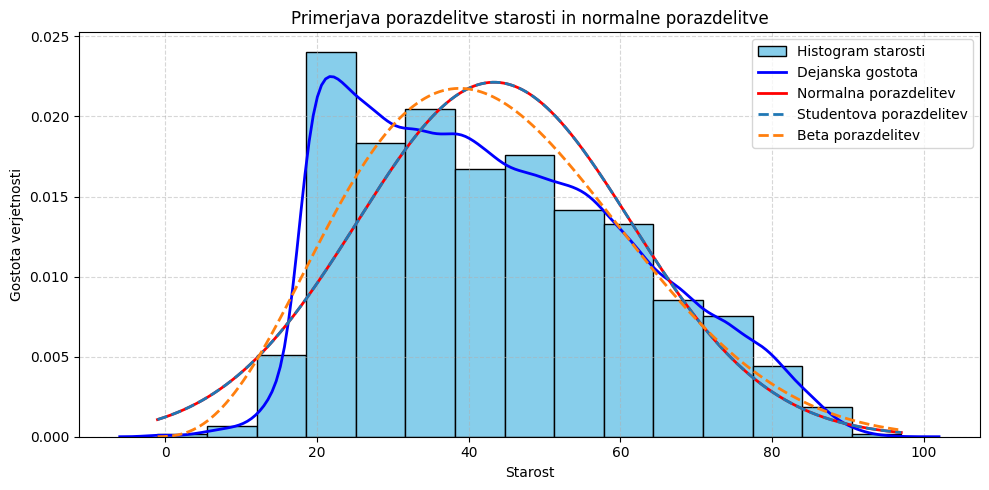

In [386]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn, t as student, beta

povzrocitelji = data[data["Povzrocitelj"] == "POVZROČITELJ"]
starosti = povzrocitelji["Starost"].dropna()

plt.figure(figsize=(10, 5))
plt.hist(starosti, bins=15, color='skyblue', edgecolor='black', density=True, label='Histogram starosti')

#Dejanska
sns.kdeplot(starosti, color='blue', linewidth=2, label='Dejanska gostota')

# Normalna
mu = starosti.mean()
sigma2 = (len(starosti) - 1) / len(starosti) * starosti.var()

xr = np.linspace(starosti.min(), starosti.max(), 1000)
P = [mvn.pdf(x, mu, sigma2) for x in xr]

plt.plot(xr, P, color='red', linewidth=2, label='Normalna porazdelitev')

#Studentova
pars = student.fit(starosti)
P_fit = [student.pdf(x, *pars) for x in xr ]

plt.plot(xr, P_fit, linestyle='--', label="Studentova porazdelitev", linewidth=2.0)

#Beta
parameters = beta.fit(starosti)
P_beta = [beta.pdf(x, *parameters) for x in xr]

plt.plot(xr, P_beta, linestyle='--', label="Beta porazdelitev", linewidth=2.0)

plt.title("Primerjava porazdelitve starosti in normalne porazdelitve")
plt.xlabel("Starost")
plt.ylabel("Gostota verjetnosti")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("poStarosti.png", dpi=300, bbox_inches="tight")
plt.show()



## Porazdelitev nesreč glede na vreme

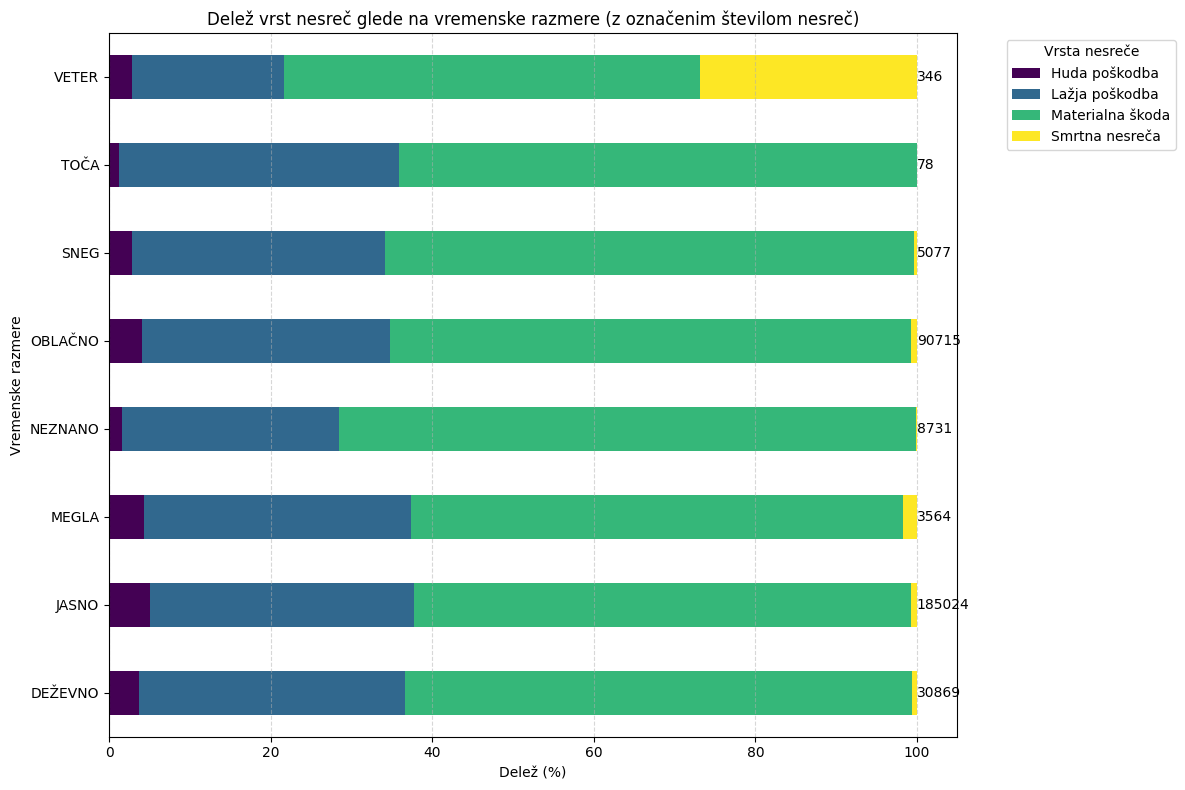

In [374]:
resnost_map = {
    'Z MATERIALNO ŠKODO': 'Materialna škoda',
    'Z LAŽJO TELESNO POŠKODBO': 'Lažja poškodba',
    'S HUDO TELESNO POŠKODBO': 'Huda poškodba',
    'S SMRTNIM IZIDOM': 'Smrtna nesreča'
}

filtered = data.dropna(subset=['KlasifikacijaNesrece', 'VremenskeOkoliscine']).copy()
filtered['Resnost'] = filtered['KlasifikacijaNesrece'].map(resnost_map)

resnost_po_vremenu = (
    filtered.groupby(['VremenskeOkoliscine', 'Resnost'])
    .size()
    .unstack(fill_value=0)
)

total_counts = resnost_po_vremenu.sum(axis=1)

resnost_po_vremenu_pct = resnost_po_vremenu.div(total_counts, axis=0) * 100

ax = resnost_po_vremenu_pct.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    colormap='viridis'
)

for i, (index, total) in enumerate(total_counts.items()):
    ax.text(100, i, f'{total}', va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Delež (%)')
plt.ylabel('Vremenske razmere')
plt.title('Delež vrst nesreč glede na vremenske razmere (z označenim številom nesreč)')
plt.legend(title='Vrsta nesreče', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


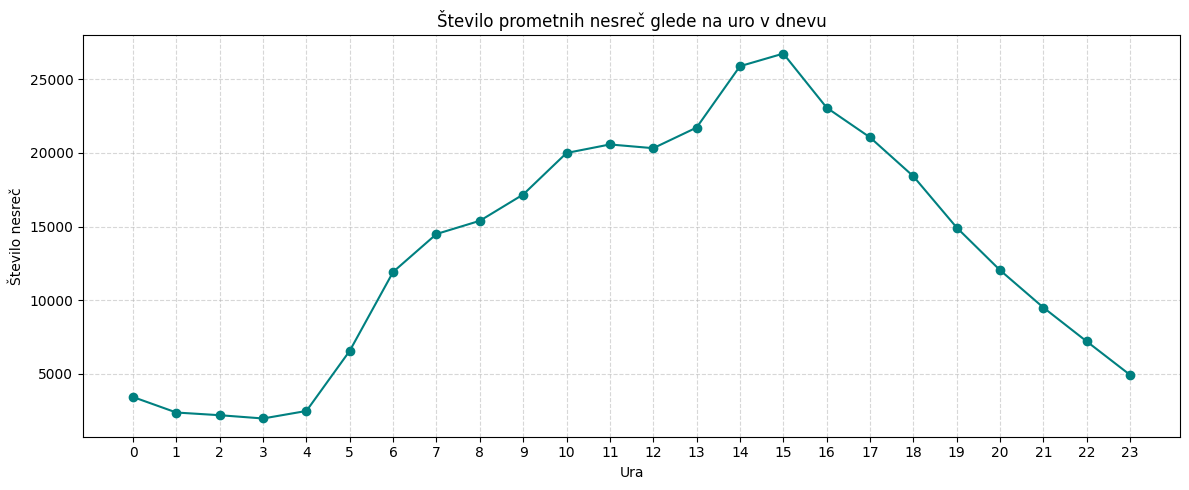

In [356]:
hourly_counts = data.dropna(subset=['UraPN'])['UraPN'].astype(int).value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', color='teal')
plt.xticks(range(0, 24))
plt.title('Število prometnih nesreč glede na uro v dnevu')
plt.xlabel('Ura')
plt.ylabel('Število nesreč')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


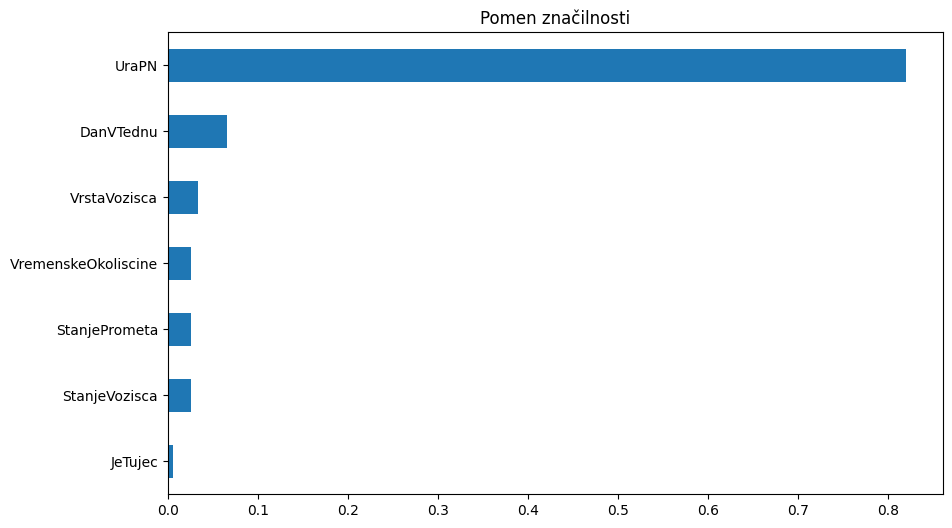

In [372]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df = data.copy()

resnost_map = {
    'Z MATERIALNO ŠKODO': 0,
    'Z LAŽJO TELESNO POŠKODBO': 1,
    'S HUDO TELESNO POŠKODBO': 2,
    'S SMRTNIM IZIDOM': 3
}

df['ResnostNum'] = df['KlasifikacijaNesrece'].map(resnost_map)

df['DatumPN'] = pd.to_datetime(df['DatumPN'], dayfirst=True, errors='coerce')
df['DanVTednu'] = df['DatumPN'].dt.dayofweek

df.dropna(subset=['UraPN', 'ResnostNum'], inplace=True)

df['JeTujec'] = (df['Drzavljanstvo'].str.upper() != "SLOVENIJA").astype(int)

features = ['UraPN', 'DanVTednu', 'JeTujec',
            'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca', 'VrstaVozisca']

model_df = df[features + ['ResnostNum']].dropna()

cat_cols = ['VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca', 'VrstaVozisca']
model_df_encoded = model_df.copy()

for col in cat_cols:
    model_df_encoded[col] = model_df_encoded[col].astype(str)
    model_df_encoded[col] = LabelEncoder().fit_transform(model_df_encoded[col])

X = model_df_encoded[features]
y = model_df_encoded['ResnostNum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model = RandomForestClassifier(n_estimators=100, random_state=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 6), title="Pomen značilnosti")
plt.show()

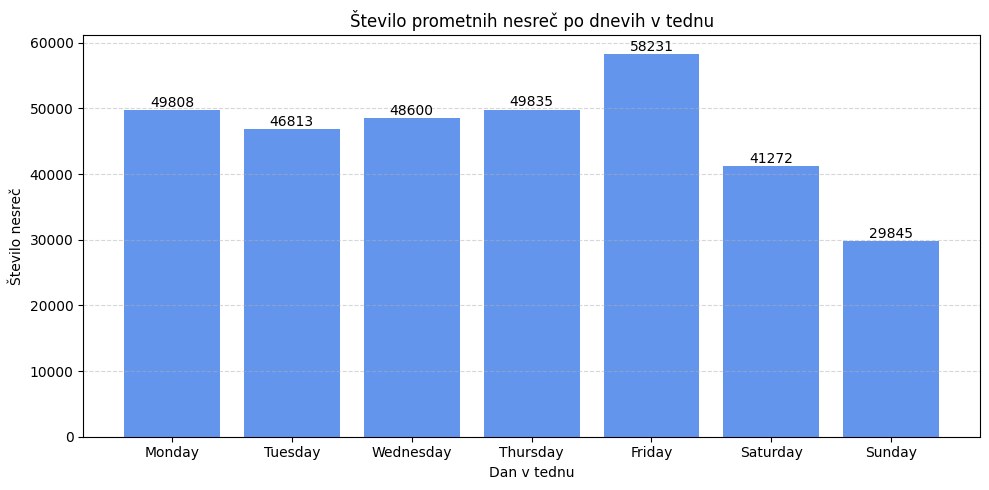

In [373]:
data['DatumPN_clean'] = pd.to_datetime(data['DatumPN'], format='%d.%m.%Y', errors='coerce')
data['DanVTednu'] = data['DatumPN_clean'].dt.day_name()  # Returns names like "Monday", "Tuesday", etc.

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = data['DanVTednu'].value_counts().reindex(ordered_days)

plt.figure(figsize=(10, 5))
bars = plt.bar(weekday_counts.index, weekday_counts.values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 20, f'{height:.0f}', ha='center', va='bottom')

plt.title('Število prometnih nesreč po dnevih v tednu')
plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


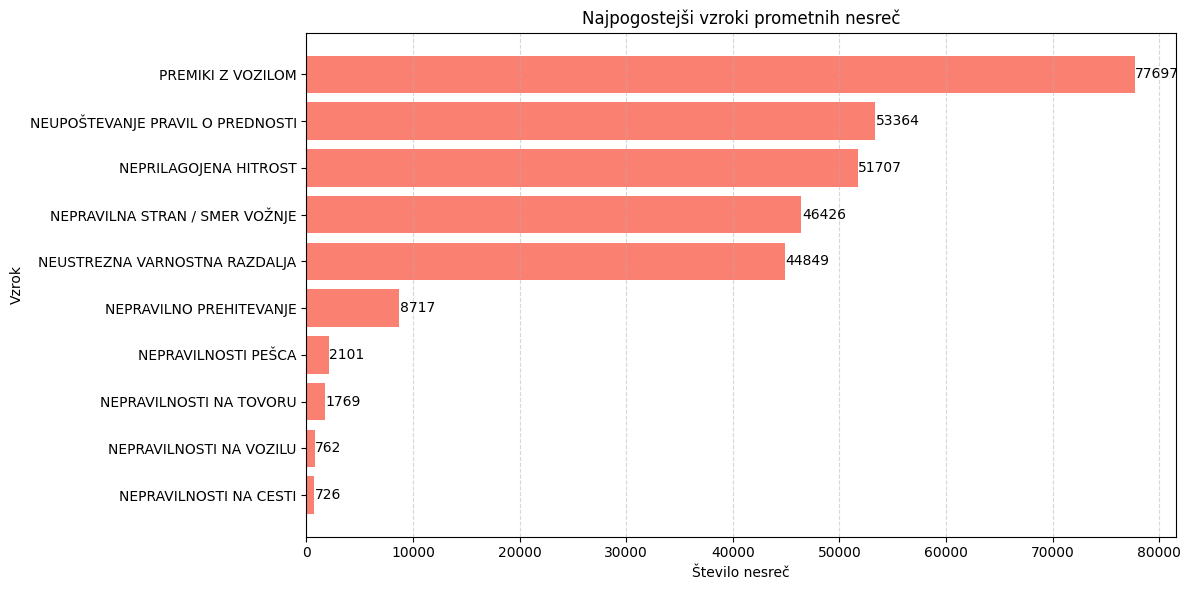

In [359]:
top_vzroki = data[data["VzrokNesrece"] != "OSTALO"]
top_vzroki = top_vzroki['VzrokNesrece'].value_counts().head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(top_vzroki.index[::-1], top_vzroki.values[::-1], color='salmon')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center')

plt.title('Najpogostejši vzroki prometnih nesreč')
plt.xlabel('Število nesreč')
plt.ylabel('Vzrok')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Najmlajši povzročitelj nesreče

In [360]:
data_cleaned = data[data['Starost'].notna() & (data['Starost'] > 0)]

youngest_perpetrator = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ'].sort_values(by='Starost').iloc[0]

print("Najmlajši povzročitelj nesreče - Starost:")
print(youngest_perpetrator['Starost'])

print("\nDruge informacije o najmlajšem povzročitelju nesreče:")
print(youngest_perpetrator)


Najmlajši povzročitelj nesreče - Starost:
1

Druge informacije o najmlajšem povzročitelju nesreče:
ZaporednaStevilkaPN                                     3002
KlasifikacijaNesrece                Z LAŽJO TELESNO POŠKODBO
UpravnaEnotaStoritve                               LJUBLJANA
DatumPN                                           01.04.2021
UraPN                                                   9.15
VNaselju                                                  DA
Lokacija                                             NASELJE
VrstaCesteNaselja              NASELJE BREZ ULIČNEGA SISTEMA
SifraCesteNaselja                                      28127
TekstCesteNaselja                        PREVALJE POD KRIMOM
SifraOdsekaUlice                                           0
TekstOdsekaUlice                                  NI ODSEKOV
StacionazaDogodka                                         18
OpisKraja                                              CESTA
VzrokNesrece                             NEPRAV

## Najmlajši povzročitelj nesreče

In [361]:
oldest_perpetrator = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ'].sort_values(by='Starost', ascending=False).iloc[0]

print("Najstarejši povzročitelj nesreče - Starost:")
print(oldest_perpetrator['Starost'])

print("\nDruge informacije o najstarejšem povzročitelju nesreče:")
print(oldest_perpetrator)


Najstarejši povzročitelj nesreče - Starost:
97

Druge informacije o najstarejšem povzročitelju nesreče:
ZaporednaStevilkaPN                                 11235
KlasifikacijaNesrece             Z LAŽJO TELESNO POŠKODBO
UpravnaEnotaStoritve                               KAMNIK
DatumPN                                        18.08.2019
UraPN                                                11.4
VNaselju                                               NE
Lokacija                                            CESTA
VrstaCesteNaselja                        REGIONALNA CESTA
SifraCesteNaselja                                   00225
TekstCesteNaselja               MENGEŠ-DUPLICA-ŠENTRUPERT
SifraOdsekaUlice                                     1140
TekstOdsekaUlice                           MENGEŠ-DUPLICA
StacionazaDogodka                                    1940
OpisKraja                                        KRIŽIŠČE
VzrokNesrece                        NEPRILAGOJENA HITROST
TipNesrece                

In [362]:
gender_counts = data_cleaned[data_cleaned['Povzrocitelj'] == 'POVZROČITELJ']['Spol'].value_counts()

print("Spol, ki je najpogostejši krivec za prometne nesreče:")
print(gender_counts)


Spol, ki je najpogostejši krivec za prometne nesreče:
Spol
MOŠKI     110862
ŽENSKI     40782
NEZNAN         1
Name: count, dtype: int64


##  Koliko od moških in žensk je bilo Slovencev in koliko tujcev

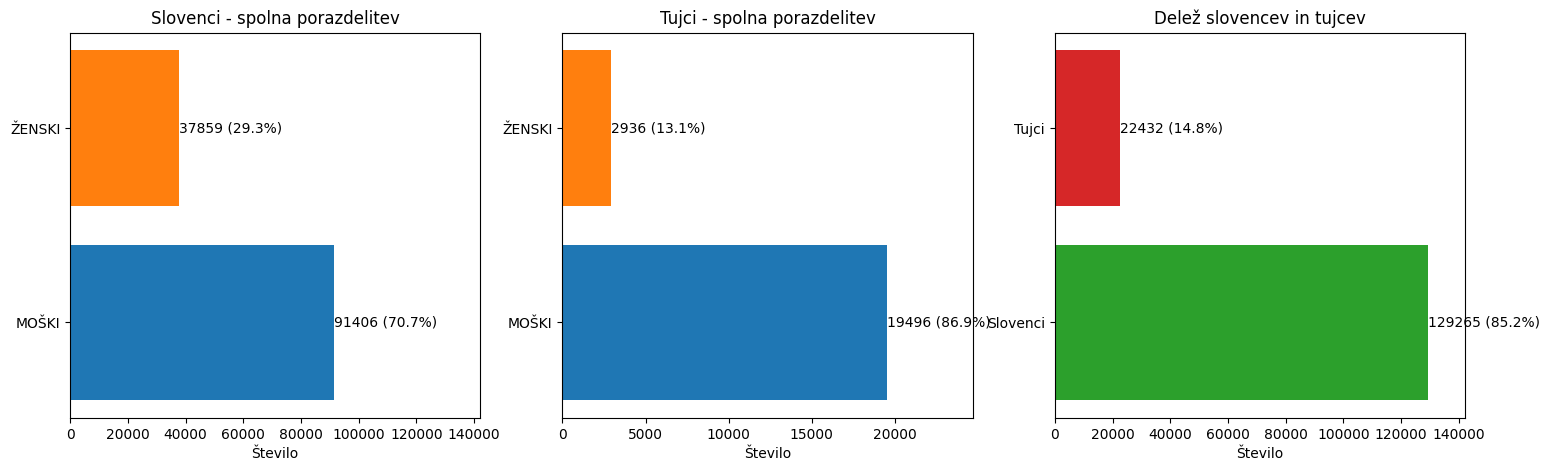

In [363]:
slovenci = povzrocitelji[povzrocitelji['Drzavljanstvo'] == 'SLOVENIJA']
tujci = povzrocitelji[povzrocitelji['Drzavljanstvo'] != 'SLOVENIJA']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Slovenci
slovenci_spol = slovenci[slovenci["Spol"] != "NEZNAN"]["Spol"].value_counts()

axes[0].barh(slovenci_spol.index, slovenci_spol.values, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Slovenci - spolna porazdelitev')
axes[0].set_xlabel('Število')
axes[0].set_xlim(0, slovenci_spol.sum() * 1.1)
for i, (count, label) in enumerate(zip(slovenci_spol.values, slovenci_spol.index)):
    percentage = (count / slovenci_spol.sum()) * 100
    axes[0].text(count + 1, i, f"{count} ({percentage:.1f}%)", va='center')

#Tujci
tujci_spol = tujci[tujci["Spol"] != "NEZNAN"]["Spol"].value_counts()

axes[1].barh(tujci_spol.index, tujci_spol.values, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Tujci - spolna porazdelitev')
axes[1].set_xlabel('Število')
axes[1].set_xlim(0, tujci_spol.sum() * 1.1)
for i, (count, label) in enumerate(zip(tujci_spol.values, tujci_spol.index)):
    percentage = (count / tujci_spol.sum()) * 100
    axes[1].text(count + 1, i, f"{count} ({percentage:.1f}%)", va='center')

#Skupaj
total_slovenci = slovenci_spol.sum()
total_tujci = tujci_spol.sum()
axes[2].barh(['Slovenci', 'Tujci'], [total_slovenci, total_tujci], color=['#2ca02c', '#d62728'])
axes[2].set_title('Delež slovencev in tujcev')
axes[2].set_xlabel('Število')
axes[2].set_xlim(0, max(total_slovenci, total_tujci) * 1.1)
for i, (count, label) in enumerate(zip([total_slovenci, total_tujci], ['Slovenci', 'Tujci'])):
    total = total_slovenci + total_tujci
    percentage = (count / total) * 100 if total > 0 else 0
    axes[2].text(count + 1, i, f"{count} ({percentage:.1f}%)", va='center')

plt.show()


KOLIKO NESREČ SO POVZROČILI TUJI VOZNIKI (VOZNIKI KI NISO IZ SLOVENIJE)

C:\Users\Tilen\AppData\Local\Temp\ipykernel_16828\373547833.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



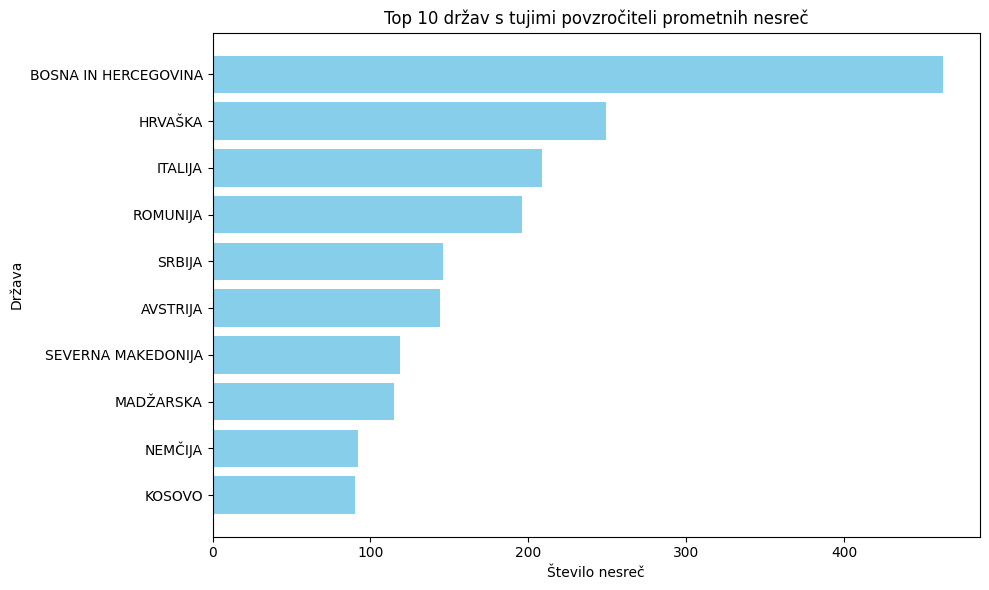

In [364]:
povzrocitelji["Tujec"] = povzrocitelji["Drzavljanstvo"].str.upper() != "SLOVENIJA"
unikatne_nesrece = povzrocitelji.drop_duplicates(subset="ZaporednaStevilkaPN")
tuji_povzrocitelji = unikatne_nesrece[unikatne_nesrece["Tujec"] == True]
drzave_top = tuji_povzrocitelji["Drzavljanstvo"].value_counts().head(10)

plt.figure(figsize=(10, 6))
plt.barh(drzave_top.index, drzave_top.values, color='skyblue')
plt.xlabel("Število nesreč")
plt.ylabel("Država")
plt.title("Top 10 držav s tujimi povzročiteli prometnih nesreč")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


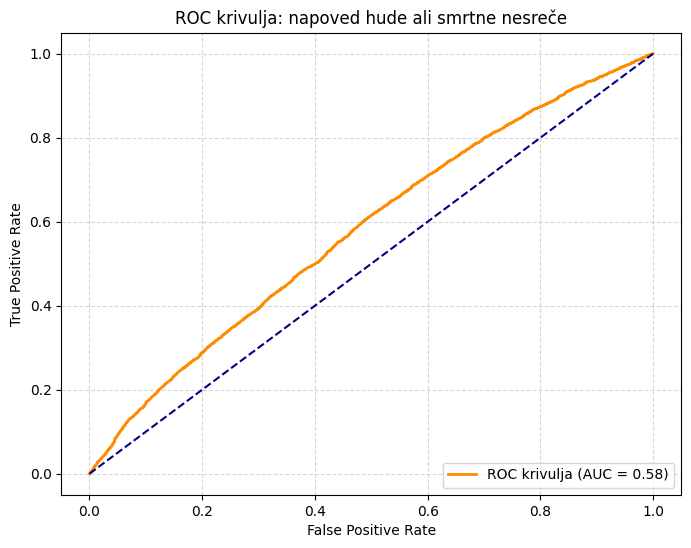

In [365]:
df['HudaAliSmrtna'] = df['ResnostNum'].isin([2, 3]).astype(int)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

df['HudaAliSmrtna'] = df['ResnostNum'].isin([2, 3]).astype(int)

cat_cols = ['VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca', 'VrstaVozisca']
df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

features = ['UraPN', 'DanVTednu', 'JeTujec',
            'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca', 'VrstaVozisca']
model_df = df_encoded[features + ['HudaAliSmrtna']].dropna()

X = model_df[features].values
y = model_df['HudaAliSmrtna'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_proba = classifier.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivulja (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC krivulja: napoved hude ali smrtne nesreče')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
